In [ ]:
import tensorflow as tf
import zipfile
print(tf.version.VERSION)

2.14.0


In [ ]:
import glob
import numpy as np
#X 1.05 Y 1.35
#labels = ['Reposo','Normal','Falla1']
labels = ['Reposo','Normal','Falla1']
x_recordings = []
y_recordings = []
recordings_filenames = []

max_rows = 2097  # Número máximo de filas a leer
for i, label in enumerate(labels):
    filenames = glob.glob('/content/'+ label + '.csv')
    for filename in filenames:
        # Cargar solo las primeras 2097 filas del archivo CSV
        data = np.loadtxt(filename, delimiter=',', max_rows=max_rows)
       # data = np.loadtxt(filename, delimiter=',')
        x_recordings.append(data)
        y_recordings.append(i)
        recordings_filenames.append(filename)

        # Combinar los arreglos cargados en un solo arreglo NumPy
x_recordings = np.array(x_recordings)
# Asegurarse de que todos los arreglos tengan la misma forma
x_recordings = x_recordings.reshape(x_recordings.shape[0], -1, 3)


#x_recordings = np.array(x_recordings).reshape(len(x_recordings), -1, 3)
y_recordings = np.array(y_recordings)

print(x_recordings.shape)
print(y_recordings.shape)

(3, 2097, 3)
(3,)


In [ ]:
import random
import matplotlib.pyplot as plt
%matplotlib inline

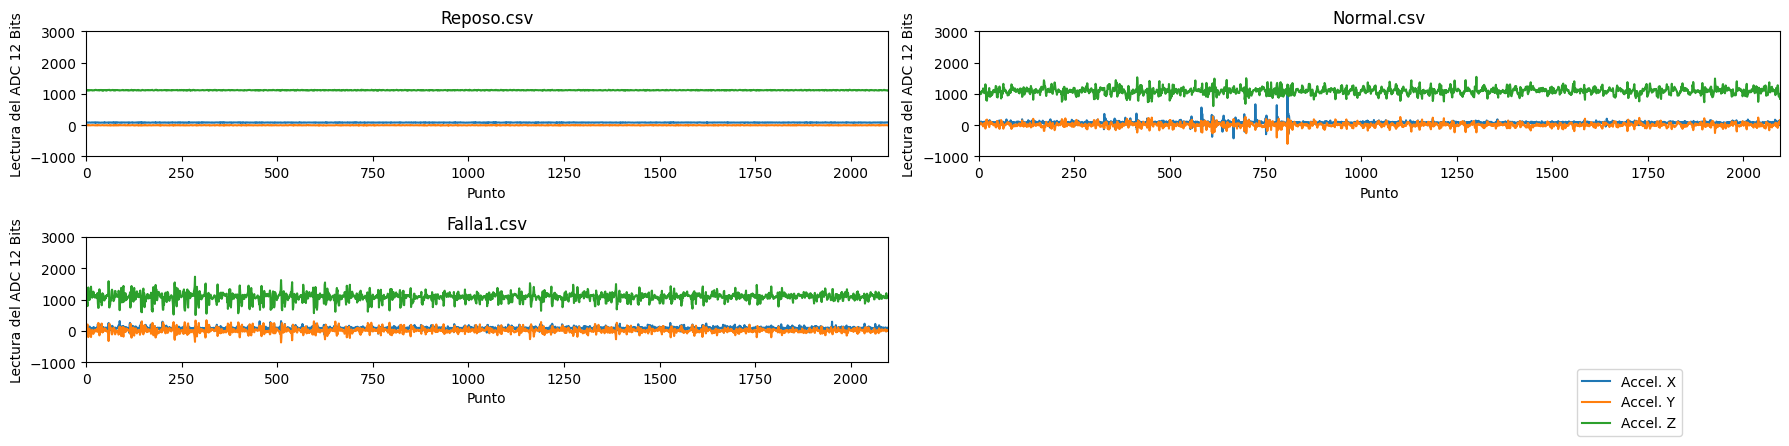

In [ ]:
# Graficando
plt.figure(figsize=(18, 10))
legends = ["Accel. X", "Accel. Y", "Accel. Z"]
for i, n in enumerate(y_recordings):
    plt.subplot(5, 2, i + 1)
    plt.margins(x=0, y=-0.25)
    plt.plot(x_recordings[n])
    plt.ylim(-1000, 3000) # 4000 mg acc. range
    plt.title(recordings_filenames[n].split('/')[-1])
    plt.xlabel("Punto")
    plt.ylabel("Lectura del ADC 12 Bits")
plt.tight_layout()
plt.legend(legends, loc='upper right', bbox_to_anchor=(2, 0))
plt.show()

In [ ]:
def frame(x, frame_len, hop_len):
    assert(x.shape == (len(x), 3))
    assert(x.shape[0] >= frame_len)
    assert(hop_len >= 1)

    n_frames = 1 + (x.shape[0] - frame_len) // hop_len
    shape = (n_frames, frame_len, x.shape[1])
    strides = ((hop_len * x.strides[0],) + x.strides)
    return np.lib.stride_tricks.as_strided(x, shape=shape, strides=strides)
x_frames = []
y_frames = []

for i in range(x_recordings.shape[0]):
    # frames = frame(x_recordings[i], 26, 26) # no overlap
    frames = frame(x_recordings[i], 10, 13) # 50% overlap
    x_frames.append(frames)
    y_frames.append(np.full(frames.shape[0], y_recordings[i]))

print(np.array(x_frames).shape)
x_frames = np.concatenate(x_frames)
y_frames = np.concatenate(y_frames)
print(x_frames.shape)

# Cada etiqueta de salida es un entero entre 0 y 2:
print(y_frames.shape)
print(labels)

(3, 161, 10, 3)
(483, 10, 3)
(483,)
['Reposo', 'Normal', 'Falla1']


In [ ]:
# Normalizando de la entrada de datos entre [-1;1]
x_frames_normed = x_frames / 16000

from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(
x_frames, y_frames, test_size=0.25)
print("Trainning samples:", x_train.shape)
print("Testing samples:", x_test.shape)

Trainning samples: (362, 10, 3)
Testing samples: (121, 10, 3)


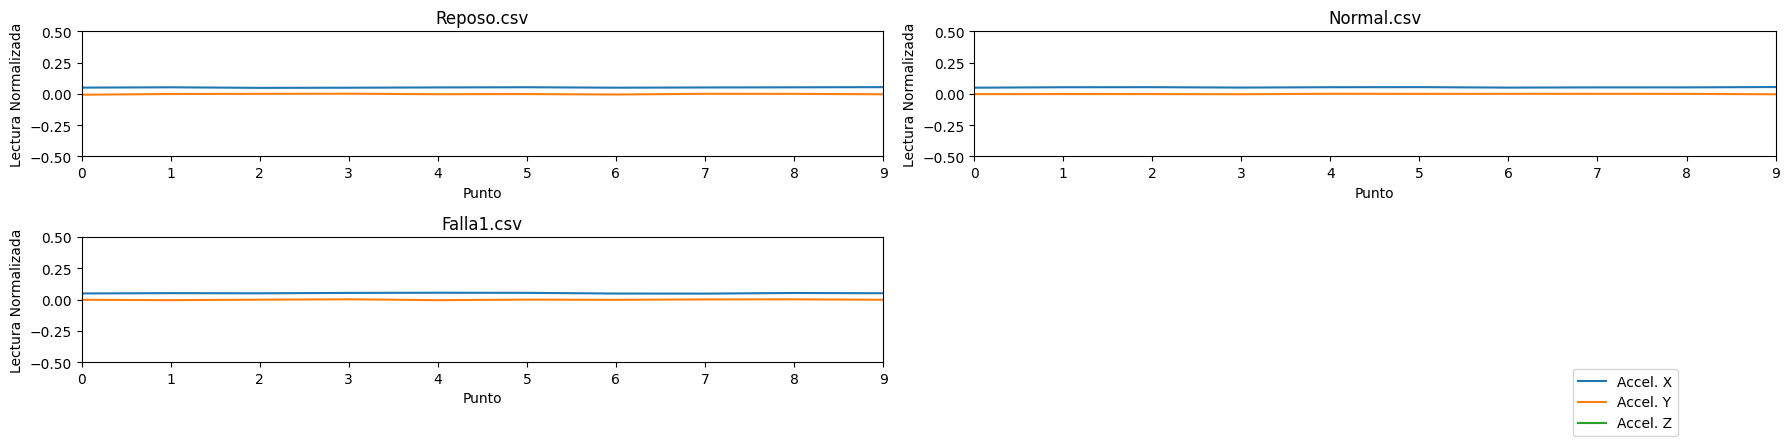

In [ ]:
# Graficando
x_frames_normed = x_frames / np.max(x_frames)
plt.figure(figsize=(18, 10))
legends = ["Accel. X", "Accel. Y", "Accel. Z"]
for i, n in enumerate(y_recordings):
    plt.subplot(5, 2, i + 1)
    plt.margins(x=0, y=-0.25)
    plt.plot(x_frames_normed[n])
    plt.ylim(-0.5, 0.5) # 4000 mg acc. range
    plt.title(recordings_filenames[n].split('/')[-1])
    plt.xlabel("Punto")
    plt.ylabel("Lectura Normalizada")
plt.tight_layout()
plt.legend(legends, loc='upper right', bbox_to_anchor=(2, 0))
plt.show()

Modelo en Keras

In [ ]:
model = tf.keras.models.Sequential([
tf.keras.layers.Conv1D(filters=16, kernel_size=5, activation='relu', input_shape=(10, 3)),
tf.keras.layers.Conv1D(filters=8, kernel_size=5, activation='relu'),
tf.keras.layers.Dropout(0.5),
tf.keras.layers.Flatten(),
tf.keras.layers.Dense(64, activation='relu'),
tf.keras.layers.Dense(3, activation='softmax')
])

model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])
model.fit(x_train, y_train, epochs=42)
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=2)
print("Test loss:", test_loss)
print("Test acc:", test_acc)
model.summary()

Epoch 1/42
12/12 [==============================] - 3s 9ms/step - loss: 33.5324 - accuracy: 0.3177
Epoch 2/42
12/12 [==============================] - 0s 9ms/step - loss: 13.6082 - accuracy: 0.3425
Epoch 3/42
12/12 [==============================] - 0s 8ms/step - loss: 5.9064 - accuracy: 0.3591
Epoch 4/42
12/12 [==============================] - 0s 14ms/step - loss: 3.6892 - accuracy: 0.3094
Epoch 5/42
12/12 [==============================] - 0s 4ms/step - loss: 2.3748 - accuracy: 0.3950
Epoch 6/42
12/12 [==============================] - 0s 8ms/step - loss: 1.9434 - accuracy: 0.3702
Epoch 7/42
12/12 [==============================] - 0s 6ms/step - loss: 1.6221 - accuracy: 0.3536
Epoch 8/42
12/12 [==============================] - 0s 6ms/step - loss: 1.3598 - accuracy: 0.4227
Epoch 9/42
12/12 [==============================] - 0s 13ms/step - loss: 1.3626 - accuracy: 0.4088
Epoch 10/42
12/12 [==============================] - 0s 16ms/step - loss: 1.1971 - accuracy: 0.4061
Epoch 11/42
12

Se analizan las metricas

In [ ]:
model.save("modelo_equipo1_motor_cnc_818.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


4/4 [==============================] - 0s 5ms/step


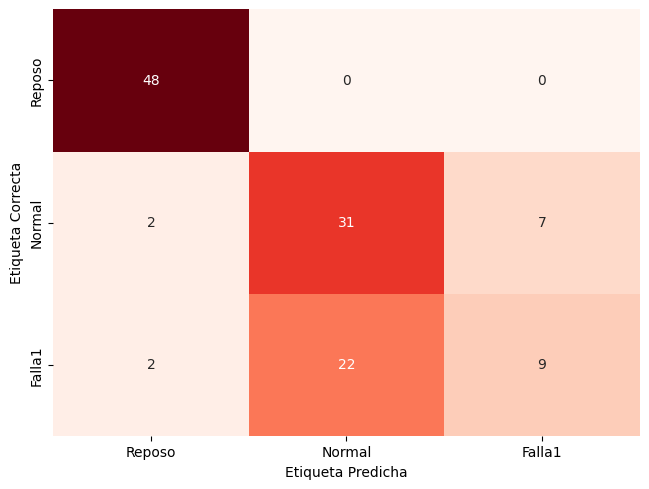

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
Y_pred = model.predict(x_test)
y_pred = np.argmax(Y_pred, axis=1)
confusion_matrix = tf.math.confusion_matrix(y_test, y_pred)
plt.figure()
sns.heatmap(confusion_matrix,
annot=True,
xticklabels=labels,
yticklabels=labels,
cmap=plt.cm.Reds,
fmt='d', cbar=False)
plt.tight_layout()
plt.ylabel('Etiqueta Correcta')
plt.xlabel('Etiqueta Predicha')
plt.show()